# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

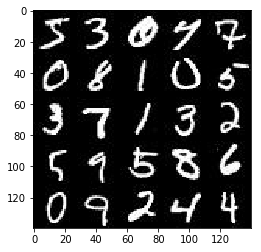

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

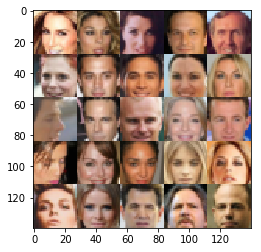

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.contrib.layers.layer_norm(x2)
        relu2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        x3 = tf.contrib.layers.layer_norm(x3)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.contrib.layers.layer_norm(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.contrib.layers.layer_norm(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.contrib.layers.layer_norm(x3)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim,alpha):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #Using WGAN-GP version
    LAMBDA = 10
    g_model = generator(input_z, out_channel_dim)
    _, d_logits_real = discriminator(input_real)
    _, d_logits_fake = discriminator(g_model, reuse=True)
    
    gen_cost = -tf.reduce_mean(d_logits_fake)
    disc_cost = tf.reduce_mean(d_logits_fake) - tf.reduce_mean(d_logits_real)

    differences = input_real - g_model
    interpolates = input_real + (alpha*differences)
    gradients = tf.gradients(discriminator(interpolates,reuse=True)[1], [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    disc_cost += LAMBDA*gradient_penalty

    return disc_cost, gen_cost


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss_WGAN_GP(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=0.9).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=0.9).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    alpha = tf.placeholder(tf.float32, input_real.get_shape().as_list(), name='alpha')
    d_loss, g_loss = model_loss(input_real, input_z,image_channels,alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    al = np.float32(np.random.uniform(0.0,1.0,size=(batch_size,image_width, image_height, image_channels)))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.float32(np.random.uniform(-1, 1, size=(batch_size, z_dim)))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,alpha:al})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images,alpha:al})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: -47.8625... Generator Loss: 15.4687
Epoch 1/2... Discriminator Loss: -79.4760... Generator Loss: 41.5288
Epoch 1/2... Discriminator Loss: -120.5674... Generator Loss: 62.6897
Epoch 1/2... Discriminator Loss: -145.3295... Generator Loss: 76.4983
Epoch 1/2... Discriminator Loss: -81.1840... Generator Loss: 5.6396
Epoch 1/2... Discriminator Loss: -169.6218... Generator Loss: 86.7235
Epoch 1/2... Discriminator Loss: -177.0828... Generator Loss: 88.8653
Epoch 1/2... Discriminator Loss: -179.8030... Generator Loss: 84.9600
Epoch 1/2... Discriminator Loss: -193.4887... Generator Loss: 94.0696
Epoch 1/2... Discriminator Loss: -211.8361... Generator Loss: 105.9336


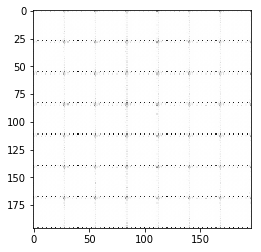

Epoch 1/2... Discriminator Loss: -225.4603... Generator Loss: 113.5360
Epoch 1/2... Discriminator Loss: -237.3232... Generator Loss: 120.3110
Epoch 1/2... Discriminator Loss: -250.8678... Generator Loss: 126.4849
Epoch 1/2... Discriminator Loss: -257.4101... Generator Loss: 126.7086
Epoch 1/2... Discriminator Loss: -89.8310... Generator Loss: -7.2101
Epoch 1/2... Discriminator Loss: -212.0868... Generator Loss: 95.5251
Epoch 1/2... Discriminator Loss: -230.5262... Generator Loss: 110.1583
Epoch 1/2... Discriminator Loss: -236.8924... Generator Loss: 111.8335
Epoch 1/2... Discriminator Loss: -269.9863... Generator Loss: 130.1068
Epoch 1/2... Discriminator Loss: -278.0590... Generator Loss: 135.0009


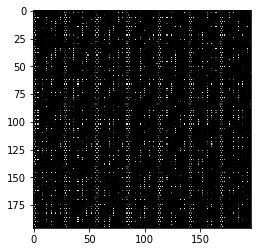

Epoch 1/2... Discriminator Loss: -262.9507... Generator Loss: 126.3613
Epoch 1/2... Discriminator Loss: -300.9971... Generator Loss: 144.1311
Epoch 1/2... Discriminator Loss: -321.5771... Generator Loss: 156.4864
Epoch 1/2... Discriminator Loss: -4.9792... Generator Loss: -78.5573
Epoch 1/2... Discriminator Loss: -107.6231... Generator Loss: -45.5325
Epoch 1/2... Discriminator Loss: -29.9887... Generator Loss: -102.6696
Epoch 1/2... Discriminator Loss: 3.1705... Generator Loss: -144.9332
Epoch 1/2... Discriminator Loss: 0.1869... Generator Loss: -128.5705
Epoch 1/2... Discriminator Loss: -5.1759... Generator Loss: -126.1964
Epoch 1/2... Discriminator Loss: -12.3118... Generator Loss: -114.7784


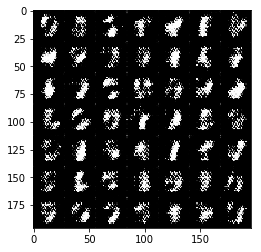

Epoch 1/2... Discriminator Loss: -12.5628... Generator Loss: -112.0550
Epoch 1/2... Discriminator Loss: -6.5608... Generator Loss: -103.9063
Epoch 1/2... Discriminator Loss: -1.0272... Generator Loss: -114.4988
Epoch 1/2... Discriminator Loss: -11.4210... Generator Loss: -114.5522
Epoch 1/2... Discriminator Loss: -6.2955... Generator Loss: -81.2904
Epoch 1/2... Discriminator Loss: -16.3657... Generator Loss: -97.1883
Epoch 1/2... Discriminator Loss: -16.0568... Generator Loss: -90.3816
Epoch 1/2... Discriminator Loss: -23.7277... Generator Loss: -84.6784
Epoch 1/2... Discriminator Loss: -12.1843... Generator Loss: -87.5447
Epoch 1/2... Discriminator Loss: -23.6009... Generator Loss: -76.9557


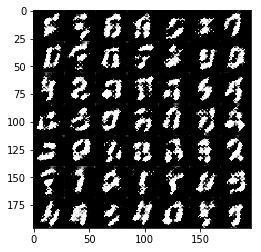

Epoch 1/2... Discriminator Loss: -10.9539... Generator Loss: -76.3400
Epoch 1/2... Discriminator Loss: -9.6599... Generator Loss: -110.0912
Epoch 1/2... Discriminator Loss: -0.8112... Generator Loss: -99.1329
Epoch 1/2... Discriminator Loss: -7.8874... Generator Loss: -96.7262
Epoch 1/2... Discriminator Loss: -13.1175... Generator Loss: -85.3414
Epoch 1/2... Discriminator Loss: 9.9144... Generator Loss: -77.9408
Epoch 1/2... Discriminator Loss: -1.0991... Generator Loss: -104.8220
Epoch 1/2... Discriminator Loss: -9.5075... Generator Loss: -48.0996
Epoch 1/2... Discriminator Loss: -2.2628... Generator Loss: -69.5888
Epoch 1/2... Discriminator Loss: -3.2099... Generator Loss: -90.3063


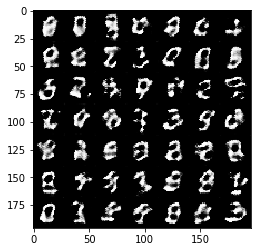

Epoch 1/2... Discriminator Loss: -4.0697... Generator Loss: -62.2531
Epoch 1/2... Discriminator Loss: -1.8294... Generator Loss: -72.1832
Epoch 1/2... Discriminator Loss: -19.2280... Generator Loss: -66.4409
Epoch 1/2... Discriminator Loss: -17.5430... Generator Loss: -75.4994
Epoch 1/2... Discriminator Loss: -19.5836... Generator Loss: -88.8686
Epoch 1/2... Discriminator Loss: -4.2041... Generator Loss: -87.2310
Epoch 1/2... Discriminator Loss: -13.2752... Generator Loss: -81.3375
Epoch 1/2... Discriminator Loss: -5.5526... Generator Loss: -82.8502
Epoch 1/2... Discriminator Loss: -3.2906... Generator Loss: -90.8930
Epoch 1/2... Discriminator Loss: -23.3582... Generator Loss: -82.5773


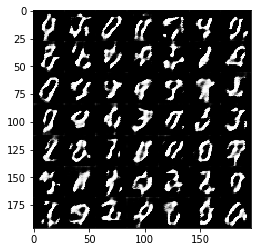

Epoch 1/2... Discriminator Loss: -22.2573... Generator Loss: -59.1277
Epoch 1/2... Discriminator Loss: -5.1587... Generator Loss: -82.8477
Epoch 1/2... Discriminator Loss: -14.6181... Generator Loss: -78.3646
Epoch 1/2... Discriminator Loss: -15.9896... Generator Loss: -81.0526
Epoch 1/2... Discriminator Loss: -13.6949... Generator Loss: -42.4002
Epoch 1/2... Discriminator Loss: -25.6013... Generator Loss: -69.0652
Epoch 1/2... Discriminator Loss: -21.5241... Generator Loss: -53.3327
Epoch 1/2... Discriminator Loss: -15.8299... Generator Loss: -38.8908
Epoch 1/2... Discriminator Loss: -16.8937... Generator Loss: -73.7414
Epoch 1/2... Discriminator Loss: -32.4232... Generator Loss: -63.2337


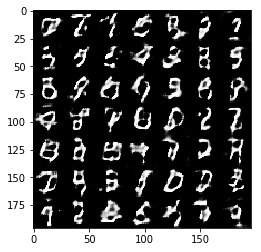

Epoch 1/2... Discriminator Loss: -25.8729... Generator Loss: -70.6465
Epoch 1/2... Discriminator Loss: -23.8708... Generator Loss: -24.7903
Epoch 1/2... Discriminator Loss: -18.6833... Generator Loss: -57.7738
Epoch 1/2... Discriminator Loss: -36.7901... Generator Loss: -44.5921
Epoch 1/2... Discriminator Loss: -25.6637... Generator Loss: -81.5839
Epoch 1/2... Discriminator Loss: -33.8911... Generator Loss: -16.2361
Epoch 1/2... Discriminator Loss: -32.7505... Generator Loss: -39.6372
Epoch 1/2... Discriminator Loss: -4.9666... Generator Loss: -58.9308
Epoch 1/2... Discriminator Loss: -25.2230... Generator Loss: -76.8914
Epoch 1/2... Discriminator Loss: -25.8769... Generator Loss: -49.9723


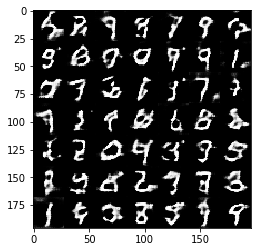

Epoch 1/2... Discriminator Loss: -35.6201... Generator Loss: -46.3383
Epoch 1/2... Discriminator Loss: -38.7741... Generator Loss: -1.5889
Epoch 1/2... Discriminator Loss: -40.6690... Generator Loss: -66.6982
Epoch 1/2... Discriminator Loss: -36.7304... Generator Loss: -51.3779
Epoch 1/2... Discriminator Loss: -32.1901... Generator Loss: 7.3297
Epoch 1/2... Discriminator Loss: 28.6969... Generator Loss: -26.6223
Epoch 1/2... Discriminator Loss: -3.1012... Generator Loss: 21.5383
Epoch 1/2... Discriminator Loss: 6.0619... Generator Loss: 7.7367
Epoch 1/2... Discriminator Loss: 26.3762... Generator Loss: -67.9062
Epoch 1/2... Discriminator Loss: -9.0657... Generator Loss: -71.0976


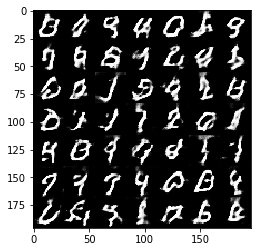

Epoch 1/2... Discriminator Loss: -8.9181... Generator Loss: -32.2511
Epoch 1/2... Discriminator Loss: -43.8754... Generator Loss: -82.8883
Epoch 1/2... Discriminator Loss: -22.5203... Generator Loss: 24.5130
Epoch 2/2... Discriminator Loss: -19.0283... Generator Loss: -100.8103
Epoch 2/2... Discriminator Loss: -45.9514... Generator Loss: -104.5288
Epoch 2/2... Discriminator Loss: -19.4212... Generator Loss: -25.8277
Epoch 2/2... Discriminator Loss: -29.1635... Generator Loss: -40.2322
Epoch 2/2... Discriminator Loss: -33.4980... Generator Loss: -16.2405
Epoch 2/2... Discriminator Loss: -23.1789... Generator Loss: -63.0118
Epoch 2/2... Discriminator Loss: -25.0606... Generator Loss: -90.0913


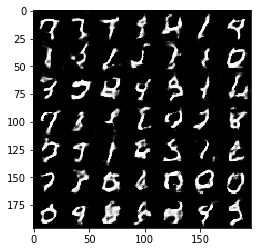

Epoch 2/2... Discriminator Loss: -34.9743... Generator Loss: -69.9697
Epoch 2/2... Discriminator Loss: -56.5901... Generator Loss: -12.7881
Epoch 2/2... Discriminator Loss: -30.5403... Generator Loss: -96.7515
Epoch 2/2... Discriminator Loss: -32.1707... Generator Loss: -82.7206
Epoch 2/2... Discriminator Loss: -51.0935... Generator Loss: -102.4361
Epoch 2/2... Discriminator Loss: -49.8079... Generator Loss: -63.3633
Epoch 2/2... Discriminator Loss: -29.1418... Generator Loss: -61.5313
Epoch 2/2... Discriminator Loss: -46.0797... Generator Loss: -110.4967
Epoch 2/2... Discriminator Loss: -44.3409... Generator Loss: -90.9372
Epoch 2/2... Discriminator Loss: -38.3910... Generator Loss: -45.9695


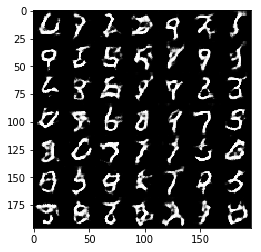

Epoch 2/2... Discriminator Loss: -60.4062... Generator Loss: -42.5396
Epoch 2/2... Discriminator Loss: -44.7028... Generator Loss: -93.9978
Epoch 2/2... Discriminator Loss: -61.1475... Generator Loss: -84.5258
Epoch 2/2... Discriminator Loss: -75.5412... Generator Loss: -113.1501
Epoch 2/2... Discriminator Loss: -52.6582... Generator Loss: -70.1270
Epoch 2/2... Discriminator Loss: -53.0829... Generator Loss: -130.1964
Epoch 2/2... Discriminator Loss: -73.1378... Generator Loss: -71.3951
Epoch 2/2... Discriminator Loss: -64.1749... Generator Loss: -89.6730
Epoch 2/2... Discriminator Loss: -60.1240... Generator Loss: -77.1346
Epoch 2/2... Discriminator Loss: -71.7911... Generator Loss: -79.2032


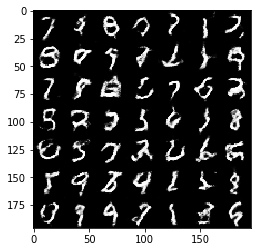

Epoch 2/2... Discriminator Loss: -106.9545... Generator Loss: -68.9813
Epoch 2/2... Discriminator Loss: -69.3001... Generator Loss: -106.9570
Epoch 2/2... Discriminator Loss: -69.6680... Generator Loss: -89.4483
Epoch 2/2... Discriminator Loss: -89.8500... Generator Loss: -38.5902
Epoch 2/2... Discriminator Loss: -79.7360... Generator Loss: -107.0466
Epoch 2/2... Discriminator Loss: -88.8635... Generator Loss: -83.7571
Epoch 2/2... Discriminator Loss: -83.5522... Generator Loss: -95.8849
Epoch 2/2... Discriminator Loss: -80.0996... Generator Loss: -99.3073
Epoch 2/2... Discriminator Loss: -89.9779... Generator Loss: -123.0540
Epoch 2/2... Discriminator Loss: -79.8847... Generator Loss: -90.9304


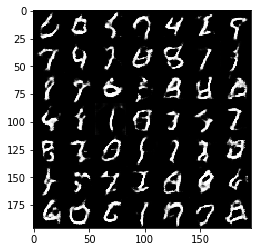

Epoch 2/2... Discriminator Loss: -95.9624... Generator Loss: -97.5628
Epoch 2/2... Discriminator Loss: -75.6112... Generator Loss: -137.9478
Epoch 2/2... Discriminator Loss: -101.0578... Generator Loss: -93.6279
Epoch 2/2... Discriminator Loss: -30.1406... Generator Loss: -60.0989
Epoch 2/2... Discriminator Loss: -83.9655... Generator Loss: -121.6233
Epoch 2/2... Discriminator Loss: -92.9957... Generator Loss: -109.2118
Epoch 2/2... Discriminator Loss: -107.9713... Generator Loss: -109.9223
Epoch 2/2... Discriminator Loss: -145.4680... Generator Loss: -23.3410
Epoch 2/2... Discriminator Loss: -107.4243... Generator Loss: -108.5815
Epoch 2/2... Discriminator Loss: -85.5138... Generator Loss: -124.4773


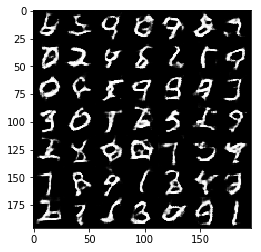

Epoch 2/2... Discriminator Loss: -101.2445... Generator Loss: -99.4793
Epoch 2/2... Discriminator Loss: -106.9504... Generator Loss: -55.8578
Epoch 2/2... Discriminator Loss: -70.3932... Generator Loss: -139.3852
Epoch 2/2... Discriminator Loss: -132.7737... Generator Loss: -87.5198
Epoch 2/2... Discriminator Loss: -111.4201... Generator Loss: -105.8234
Epoch 2/2... Discriminator Loss: -118.8744... Generator Loss: -77.7264
Epoch 2/2... Discriminator Loss: -104.0811... Generator Loss: -146.7924
Epoch 2/2... Discriminator Loss: -96.9725... Generator Loss: -156.5989
Epoch 2/2... Discriminator Loss: -120.1595... Generator Loss: -7.5917
Epoch 2/2... Discriminator Loss: -119.2998... Generator Loss: -113.5245


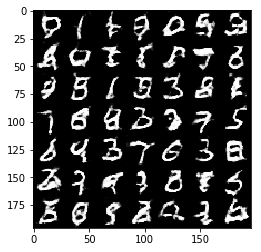

Epoch 2/2... Discriminator Loss: -146.7589... Generator Loss: -84.5231
Epoch 2/2... Discriminator Loss: -109.9136... Generator Loss: -143.8708
Epoch 2/2... Discriminator Loss: -134.4844... Generator Loss: -109.2484
Epoch 2/2... Discriminator Loss: -100.3151... Generator Loss: -103.6474
Epoch 2/2... Discriminator Loss: -143.0681... Generator Loss: -42.2493
Epoch 2/2... Discriminator Loss: -114.8407... Generator Loss: -141.3722
Epoch 2/2... Discriminator Loss: -130.5648... Generator Loss: -86.4837
Epoch 2/2... Discriminator Loss: -116.1349... Generator Loss: -124.8122
Epoch 2/2... Discriminator Loss: -108.4055... Generator Loss: -145.9553
Epoch 2/2... Discriminator Loss: -130.4435... Generator Loss: -108.9740


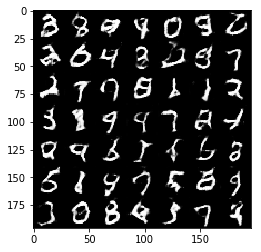

Epoch 2/2... Discriminator Loss: -114.2214... Generator Loss: -131.5888
Epoch 2/2... Discriminator Loss: -149.0916... Generator Loss: -140.5179
Epoch 2/2... Discriminator Loss: -104.5154... Generator Loss: -147.8714
Epoch 2/2... Discriminator Loss: -116.8428... Generator Loss: -143.1253
Epoch 2/2... Discriminator Loss: -146.0263... Generator Loss: -136.2942
Epoch 2/2... Discriminator Loss: -117.7010... Generator Loss: -28.2303
Epoch 2/2... Discriminator Loss: -127.1398... Generator Loss: -101.2486
Epoch 2/2... Discriminator Loss: -180.5862... Generator Loss: -86.8709
Epoch 2/2... Discriminator Loss: -144.8516... Generator Loss: -93.9416
Epoch 2/2... Discriminator Loss: -144.8594... Generator Loss: -107.6534


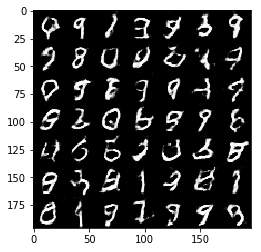

Epoch 2/2... Discriminator Loss: -138.9460... Generator Loss: -136.7286
Epoch 2/2... Discriminator Loss: -100.4245... Generator Loss: -135.3753
Epoch 2/2... Discriminator Loss: -140.4914... Generator Loss: -127.5199
Epoch 2/2... Discriminator Loss: -107.8536... Generator Loss: -146.8333
Epoch 2/2... Discriminator Loss: -156.0890... Generator Loss: -181.1436
Epoch 2/2... Discriminator Loss: -172.6816... Generator Loss: -153.4346
Epoch 2/2... Discriminator Loss: -149.9671... Generator Loss: -124.5502
Epoch 2/2... Discriminator Loss: -154.6623... Generator Loss: -149.0509
Epoch 2/2... Discriminator Loss: -211.1101... Generator Loss: -50.0309
Epoch 2/2... Discriminator Loss: -172.8466... Generator Loss: -96.4587


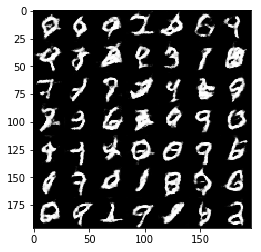

Epoch 2/2... Discriminator Loss: -135.3964... Generator Loss: -214.6569
Epoch 2/2... Discriminator Loss: -132.4942... Generator Loss: -97.3590
Epoch 2/2... Discriminator Loss: -141.9629... Generator Loss: -137.0576
Epoch 2/2... Discriminator Loss: -149.7914... Generator Loss: -183.4081
Epoch 2/2... Discriminator Loss: -169.9788... Generator Loss: -116.0320
Epoch 2/2... Discriminator Loss: -133.3520... Generator Loss: -143.0097
Epoch 2/2... Discriminator Loss: -169.2501... Generator Loss: -63.1591


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: -45.0643... Generator Loss: 12.4777
Epoch 1/1... Discriminator Loss: -87.4442... Generator Loss: 38.9269
Epoch 1/1... Discriminator Loss: -113.8099... Generator Loss: 50.0199
Epoch 1/1... Discriminator Loss: -56.1436... Generator Loss: -3.0984
Epoch 1/1... Discriminator Loss: -115.4798... Generator Loss: 46.2049
Epoch 1/1... Discriminator Loss: -112.5442... Generator Loss: 35.7065
Epoch 1/1... Discriminator Loss: -139.2840... Generator Loss: 53.5180
Epoch 1/1... Discriminator Loss: -116.6951... Generator Loss: 39.2085
Epoch 1/1... Discriminator Loss: -34.2473... Generator Loss: -34.1316
Epoch 1/1... Discriminator Loss: -98.5284... Generator Loss: 28.5250


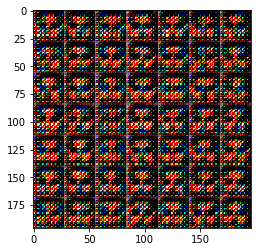

Epoch 1/1... Discriminator Loss: -125.7807... Generator Loss: 42.1238
Epoch 1/1... Discriminator Loss: -160.9814... Generator Loss: 76.2241
Epoch 1/1... Discriminator Loss: -180.4821... Generator Loss: 75.3986
Epoch 1/1... Discriminator Loss: -82.3996... Generator Loss: 8.3399
Epoch 1/1... Discriminator Loss: -128.2342... Generator Loss: 56.2508
Epoch 1/1... Discriminator Loss: -130.5253... Generator Loss: 55.6446
Epoch 1/1... Discriminator Loss: -183.6681... Generator Loss: 82.0277
Epoch 1/1... Discriminator Loss: -168.7886... Generator Loss: 85.3939
Epoch 1/1... Discriminator Loss: -188.8853... Generator Loss: 83.9358
Epoch 1/1... Discriminator Loss: -178.5897... Generator Loss: 103.3713


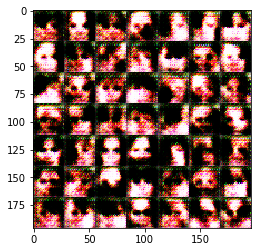

Epoch 1/1... Discriminator Loss: -214.3037... Generator Loss: 100.0314
Epoch 1/1... Discriminator Loss: -219.1990... Generator Loss: 110.0886
Epoch 1/1... Discriminator Loss: -198.2326... Generator Loss: 103.6754
Epoch 1/1... Discriminator Loss: -199.1136... Generator Loss: 117.7499
Epoch 1/1... Discriminator Loss: -104.2957... Generator Loss: 122.5310
Epoch 1/1... Discriminator Loss: -277.7590... Generator Loss: 130.5751
Epoch 1/1... Discriminator Loss: -194.7678... Generator Loss: 130.1218
Epoch 1/1... Discriminator Loss: -175.4078... Generator Loss: 122.9961
Epoch 1/1... Discriminator Loss: -81.6331... Generator Loss: 25.6214
Epoch 1/1... Discriminator Loss: -288.1194... Generator Loss: 135.9469


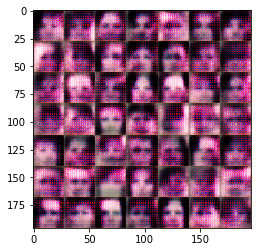

Epoch 1/1... Discriminator Loss: -118.4490... Generator Loss: 58.9786
Epoch 1/1... Discriminator Loss: 33.8512... Generator Loss: -15.3272
Epoch 1/1... Discriminator Loss: -19.1712... Generator Loss: 109.0314
Epoch 1/1... Discriminator Loss: -277.9063... Generator Loss: 134.2181
Epoch 1/1... Discriminator Loss: -14.0047... Generator Loss: 113.1626
Epoch 1/1... Discriminator Loss: -137.3636... Generator Loss: 87.9118
Epoch 1/1... Discriminator Loss: -80.1708... Generator Loss: 128.6733
Epoch 1/1... Discriminator Loss: -276.2451... Generator Loss: 119.5135
Epoch 1/1... Discriminator Loss: -252.7567... Generator Loss: 122.5336
Epoch 1/1... Discriminator Loss: -268.3539... Generator Loss: 113.2350


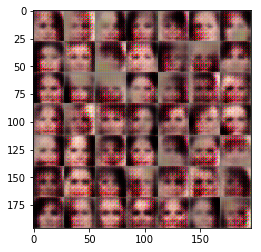

Epoch 1/1... Discriminator Loss: 63.9592... Generator Loss: -7.3557
Epoch 1/1... Discriminator Loss: -150.8151... Generator Loss: 92.9450
Epoch 1/1... Discriminator Loss: -44.8563... Generator Loss: 129.2006
Epoch 1/1... Discriminator Loss: -49.9330... Generator Loss: 103.6582
Epoch 1/1... Discriminator Loss: -85.7672... Generator Loss: 99.7387
Epoch 1/1... Discriminator Loss: 121.7138... Generator Loss: -163.2816
Epoch 1/1... Discriminator Loss: -99.7959... Generator Loss: 126.2765
Epoch 1/1... Discriminator Loss: -324.5719... Generator Loss: 142.2304
Epoch 1/1... Discriminator Loss: -57.2212... Generator Loss: 106.1138
Epoch 1/1... Discriminator Loss: -50.0538... Generator Loss: 111.4504


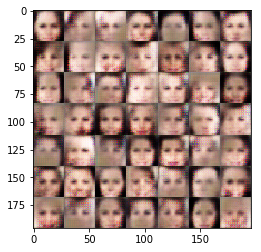

Epoch 1/1... Discriminator Loss: 39.8404... Generator Loss: -86.6684
Epoch 1/1... Discriminator Loss: -326.5332... Generator Loss: 147.4594
Epoch 1/1... Discriminator Loss: -33.0866... Generator Loss: 96.8350
Epoch 1/1... Discriminator Loss: -34.9869... Generator Loss: 141.4178
Epoch 1/1... Discriminator Loss: -123.1177... Generator Loss: 112.2139
Epoch 1/1... Discriminator Loss: -94.7663... Generator Loss: 74.6938
Epoch 1/1... Discriminator Loss: -361.1213... Generator Loss: 162.4945
Epoch 1/1... Discriminator Loss: -58.1654... Generator Loss: 114.8484
Epoch 1/1... Discriminator Loss: -261.8767... Generator Loss: 132.9992
Epoch 1/1... Discriminator Loss: -49.1971... Generator Loss: 149.6882


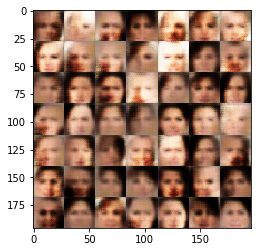

Epoch 1/1... Discriminator Loss: -42.1624... Generator Loss: 88.1470
Epoch 1/1... Discriminator Loss: -23.8887... Generator Loss: 131.7318
Epoch 1/1... Discriminator Loss: -364.6453... Generator Loss: 165.6632
Epoch 1/1... Discriminator Loss: -6.1948... Generator Loss: 159.8558
Epoch 1/1... Discriminator Loss: -183.3769... Generator Loss: 104.4078
Epoch 1/1... Discriminator Loss: -310.3585... Generator Loss: 165.5494
Epoch 1/1... Discriminator Loss: -318.7921... Generator Loss: 182.0745
Epoch 1/1... Discriminator Loss: -102.7553... Generator Loss: 170.2202
Epoch 1/1... Discriminator Loss: -446.7215... Generator Loss: 196.9594
Epoch 1/1... Discriminator Loss: -456.7731... Generator Loss: 206.9852


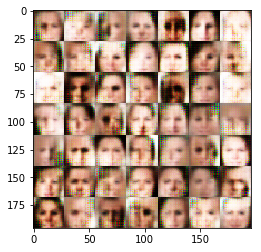

Epoch 1/1... Discriminator Loss: -341.5245... Generator Loss: 199.0054
Epoch 1/1... Discriminator Loss: -42.6115... Generator Loss: 19.4408
Epoch 1/1... Discriminator Loss: -348.1754... Generator Loss: 147.9437
Epoch 1/1... Discriminator Loss: -169.2035... Generator Loss: 96.1990
Epoch 1/1... Discriminator Loss: -219.3887... Generator Loss: 180.2396
Epoch 1/1... Discriminator Loss: -227.1876... Generator Loss: 32.1201
Epoch 1/1... Discriminator Loss: -462.5743... Generator Loss: 217.9837
Epoch 1/1... Discriminator Loss: -119.6380... Generator Loss: 138.2750
Epoch 1/1... Discriminator Loss: -341.8760... Generator Loss: 157.1865
Epoch 1/1... Discriminator Loss: -157.4499... Generator Loss: 150.5090


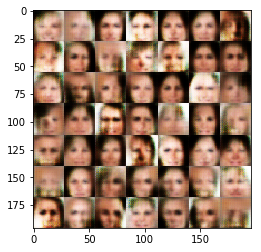

Epoch 1/1... Discriminator Loss: -419.6190... Generator Loss: 206.0592
Epoch 1/1... Discriminator Loss: -245.6158... Generator Loss: 168.7651
Epoch 1/1... Discriminator Loss: -46.8623... Generator Loss: 159.2389
Epoch 1/1... Discriminator Loss: -414.0530... Generator Loss: 209.6534
Epoch 1/1... Discriminator Loss: -20.1864... Generator Loss: 236.8821
Epoch 1/1... Discriminator Loss: -23.3068... Generator Loss: 221.9835
Epoch 1/1... Discriminator Loss: -59.5117... Generator Loss: -35.9809
Epoch 1/1... Discriminator Loss: -379.2256... Generator Loss: 232.8895
Epoch 1/1... Discriminator Loss: -46.7341... Generator Loss: 27.3158
Epoch 1/1... Discriminator Loss: -488.7532... Generator Loss: 244.0624


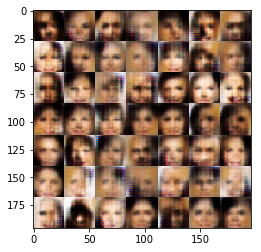

Epoch 1/1... Discriminator Loss: -202.4760... Generator Loss: -1.5817
Epoch 1/1... Discriminator Loss: -15.6036... Generator Loss: 260.0433
Epoch 1/1... Discriminator Loss: -49.1126... Generator Loss: 240.3535
Epoch 1/1... Discriminator Loss: -42.9921... Generator Loss: 237.6541
Epoch 1/1... Discriminator Loss: -316.0460... Generator Loss: 233.2999
Epoch 1/1... Discriminator Loss: -525.2587... Generator Loss: 225.0075
Epoch 1/1... Discriminator Loss: -324.9402... Generator Loss: 124.4517
Epoch 1/1... Discriminator Loss: -532.6578... Generator Loss: 254.5639
Epoch 1/1... Discriminator Loss: -34.2352... Generator Loss: 251.9202
Epoch 1/1... Discriminator Loss: 16.2890... Generator Loss: 250.9712


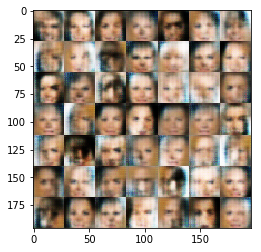

Epoch 1/1... Discriminator Loss: 10.8235... Generator Loss: 265.2445
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 262.8731
Epoch 1/1... Discriminator Loss: 6.8260... Generator Loss: 245.7461
Epoch 1/1... Discriminator Loss: -13.2379... Generator Loss: 236.5881
Epoch 1/1... Discriminator Loss: -232.3719... Generator Loss: 244.6509
Epoch 1/1... Discriminator Loss: -172.9809... Generator Loss: 266.9308
Epoch 1/1... Discriminator Loss: -40.2068... Generator Loss: 268.4034
Epoch 1/1... Discriminator Loss: -293.1351... Generator Loss: 251.9053
Epoch 1/1... Discriminator Loss: -438.2055... Generator Loss: 222.7335
Epoch 1/1... Discriminator Loss: -64.0881... Generator Loss: -135.0437


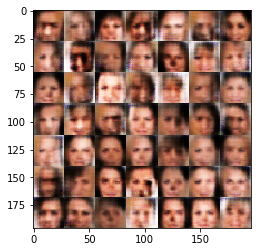

Epoch 1/1... Discriminator Loss: -552.7617... Generator Loss: 280.7627
Epoch 1/1... Discriminator Loss: -54.8866... Generator Loss: 119.2208
Epoch 1/1... Discriminator Loss: 1.9150... Generator Loss: 265.1248
Epoch 1/1... Discriminator Loss: -2.1104... Generator Loss: 271.0049
Epoch 1/1... Discriminator Loss: 5.9987... Generator Loss: 263.2905
Epoch 1/1... Discriminator Loss: -9.1034... Generator Loss: 275.9684
Epoch 1/1... Discriminator Loss: -11.8614... Generator Loss: 243.1228
Epoch 1/1... Discriminator Loss: -47.1487... Generator Loss: 228.3152
Epoch 1/1... Discriminator Loss: -141.1869... Generator Loss: 96.5402
Epoch 1/1... Discriminator Loss: -161.8900... Generator Loss: -8.7131


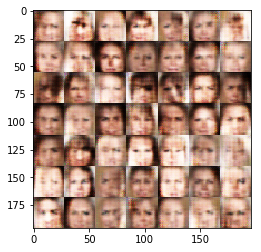

Epoch 1/1... Discriminator Loss: -142.8217... Generator Loss: 116.5519
Epoch 1/1... Discriminator Loss: -100.7947... Generator Loss: 290.8784
Epoch 1/1... Discriminator Loss: -14.9451... Generator Loss: 286.8481
Epoch 1/1... Discriminator Loss: -1.3047... Generator Loss: 283.6398
Epoch 1/1... Discriminator Loss: -69.7391... Generator Loss: 74.1471
Epoch 1/1... Discriminator Loss: -74.0779... Generator Loss: 271.3217
Epoch 1/1... Discriminator Loss: -36.1841... Generator Loss: 173.9167
Epoch 1/1... Discriminator Loss: -4.7844... Generator Loss: 254.0021
Epoch 1/1... Discriminator Loss: -36.9800... Generator Loss: 266.0250
Epoch 1/1... Discriminator Loss: -365.9422... Generator Loss: 264.0614


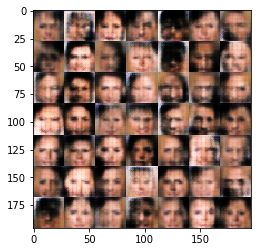

Epoch 1/1... Discriminator Loss: -40.8581... Generator Loss: -67.2924
Epoch 1/1... Discriminator Loss: -78.0285... Generator Loss: 183.4124
Epoch 1/1... Discriminator Loss: 3.5530... Generator Loss: 95.1900
Epoch 1/1... Discriminator Loss: -84.9404... Generator Loss: -91.8667
Epoch 1/1... Discriminator Loss: -318.8518... Generator Loss: 257.7495
Epoch 1/1... Discriminator Loss: -132.4960... Generator Loss: 288.1789
Epoch 1/1... Discriminator Loss: -388.6307... Generator Loss: 244.4066
Epoch 1/1... Discriminator Loss: -16.1997... Generator Loss: 276.4265
Epoch 1/1... Discriminator Loss: 2.0157... Generator Loss: 303.5185
Epoch 1/1... Discriminator Loss: -28.6702... Generator Loss: 289.9860


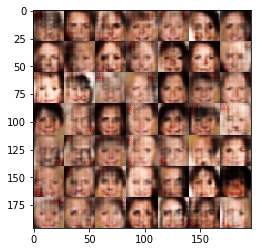

Epoch 1/1... Discriminator Loss: -27.6058... Generator Loss: 296.9554
Epoch 1/1... Discriminator Loss: 28.0182... Generator Loss: -158.0983
Epoch 1/1... Discriminator Loss: -4.5714... Generator Loss: 308.0621
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 297.6226
Epoch 1/1... Discriminator Loss: -3.5507... Generator Loss: 282.5044
Epoch 1/1... Discriminator Loss: -7.1212... Generator Loss: 286.4161
Epoch 1/1... Discriminator Loss: -35.5616... Generator Loss: 254.3038
Epoch 1/1... Discriminator Loss: -5.8677... Generator Loss: 230.5571
Epoch 1/1... Discriminator Loss: 19.1134... Generator Loss: 218.9125
Epoch 1/1... Discriminator Loss: 13.2566... Generator Loss: 262.7485


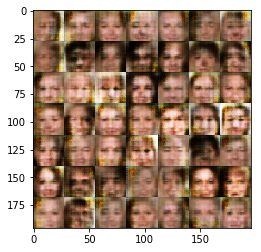

Epoch 1/1... Discriminator Loss: -2.8401... Generator Loss: 245.6065
Epoch 1/1... Discriminator Loss: -30.4721... Generator Loss: 248.9576
Epoch 1/1... Discriminator Loss: -181.2507... Generator Loss: 222.1812
Epoch 1/1... Discriminator Loss: -59.5208... Generator Loss: 297.6685
Epoch 1/1... Discriminator Loss: -51.5982... Generator Loss: 109.1145
Epoch 1/1... Discriminator Loss: -165.7229... Generator Loss: 320.6685
Epoch 1/1... Discriminator Loss: -95.9502... Generator Loss: -99.2643
Epoch 1/1... Discriminator Loss: -332.1849... Generator Loss: 247.0574
Epoch 1/1... Discriminator Loss: -171.1080... Generator Loss: 210.2911
Epoch 1/1... Discriminator Loss: -98.0953... Generator Loss: -40.4816


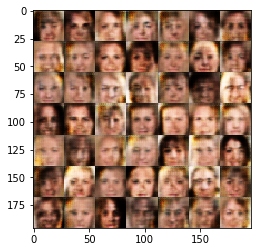

Epoch 1/1... Discriminator Loss: -122.6326... Generator Loss: 221.3716
Epoch 1/1... Discriminator Loss: -303.8874... Generator Loss: 255.0896
Epoch 1/1... Discriminator Loss: -212.1207... Generator Loss: 245.5623
Epoch 1/1... Discriminator Loss: -59.4993... Generator Loss: -53.3450
Epoch 1/1... Discriminator Loss: -34.4734... Generator Loss: -109.0369
Epoch 1/1... Discriminator Loss: -94.3262... Generator Loss: 233.9890
Epoch 1/1... Discriminator Loss: -369.4356... Generator Loss: 147.8453
Epoch 1/1... Discriminator Loss: 4.1250... Generator Loss: 290.6021
Epoch 1/1... Discriminator Loss: -0.3589... Generator Loss: 322.4961
Epoch 1/1... Discriminator Loss: -7.6587... Generator Loss: 328.2886


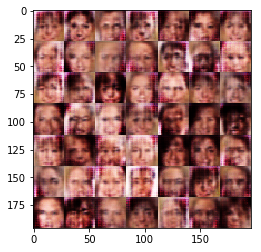

Epoch 1/1... Discriminator Loss: -49.3384... Generator Loss: 255.8602
Epoch 1/1... Discriminator Loss: -191.5340... Generator Loss: 273.0811
Epoch 1/1... Discriminator Loss: -67.2180... Generator Loss: 313.6478
Epoch 1/1... Discriminator Loss: 94.6968... Generator Loss: 169.8185
Epoch 1/1... Discriminator Loss: -2.5003... Generator Loss: 319.0285
Epoch 1/1... Discriminator Loss: -26.3153... Generator Loss: 307.8941
Epoch 1/1... Discriminator Loss: -82.4651... Generator Loss: -12.8999
Epoch 1/1... Discriminator Loss: -239.0087... Generator Loss: 23.5535
Epoch 1/1... Discriminator Loss: -65.2320... Generator Loss: 314.5108
Epoch 1/1... Discriminator Loss: -465.8194... Generator Loss: 150.7083


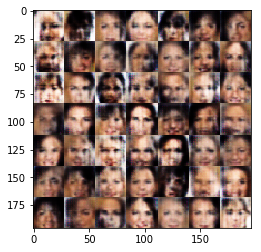

Epoch 1/1... Discriminator Loss: -67.9553... Generator Loss: 314.9041
Epoch 1/1... Discriminator Loss: -402.7830... Generator Loss: 206.1671
Epoch 1/1... Discriminator Loss: -427.6954... Generator Loss: 349.3670
Epoch 1/1... Discriminator Loss: -166.1415... Generator Loss: 25.9289
Epoch 1/1... Discriminator Loss: -136.4604... Generator Loss: -151.3370
Epoch 1/1... Discriminator Loss: -17.5843... Generator Loss: 362.9823
Epoch 1/1... Discriminator Loss: -211.2424... Generator Loss: 349.9213
Epoch 1/1... Discriminator Loss: -158.5871... Generator Loss: 258.5332
Epoch 1/1... Discriminator Loss: -461.5954... Generator Loss: 247.3818
Epoch 1/1... Discriminator Loss: -261.3194... Generator Loss: 190.6667


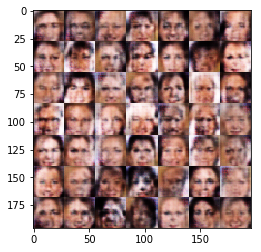

Epoch 1/1... Discriminator Loss: -294.9695... Generator Loss: 273.2040
Epoch 1/1... Discriminator Loss: -185.5872... Generator Loss: 278.9486
Epoch 1/1... Discriminator Loss: -65.5303... Generator Loss: 300.6707
Epoch 1/1... Discriminator Loss: -167.3836... Generator Loss: 257.8204
Epoch 1/1... Discriminator Loss: -323.0335... Generator Loss: 49.5077
Epoch 1/1... Discriminator Loss: -44.2783... Generator Loss: 354.8442
Epoch 1/1... Discriminator Loss: -467.2460... Generator Loss: 280.3268
Epoch 1/1... Discriminator Loss: -36.8195... Generator Loss: 79.3169
Epoch 1/1... Discriminator Loss: -60.0166... Generator Loss: -159.3388
Epoch 1/1... Discriminator Loss: -454.1369... Generator Loss: 216.3572


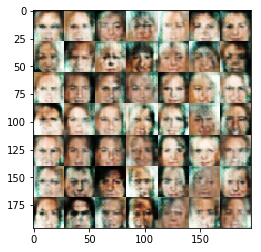

Epoch 1/1... Discriminator Loss: -211.5959... Generator Loss: -48.4679
Epoch 1/1... Discriminator Loss: -146.7019... Generator Loss: 148.5611
Epoch 1/1... Discriminator Loss: 16.0039... Generator Loss: -322.6740
Epoch 1/1... Discriminator Loss: -21.4746... Generator Loss: 391.4643
Epoch 1/1... Discriminator Loss: -229.5026... Generator Loss: 70.2105
Epoch 1/1... Discriminator Loss: -266.0783... Generator Loss: -52.7123
Epoch 1/1... Discriminator Loss: -50.7469... Generator Loss: -197.4377
Epoch 1/1... Discriminator Loss: -191.6087... Generator Loss: -141.7838
Epoch 1/1... Discriminator Loss: -230.8832... Generator Loss: 45.1318
Epoch 1/1... Discriminator Loss: -163.8534... Generator Loss: 405.7671


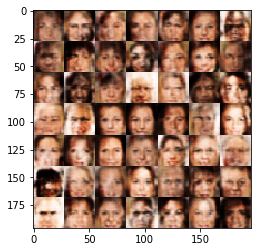

Epoch 1/1... Discriminator Loss: -4.3052... Generator Loss: 386.6686
Epoch 1/1... Discriminator Loss: 9.2844... Generator Loss: 381.5980
Epoch 1/1... Discriminator Loss: -5.8835... Generator Loss: 403.2241
Epoch 1/1... Discriminator Loss: -28.6847... Generator Loss: 355.7430
Epoch 1/1... Discriminator Loss: -145.4210... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: -144.7897... Generator Loss: 15.1797
Epoch 1/1... Discriminator Loss: -134.6244... Generator Loss: -140.6441
Epoch 1/1... Discriminator Loss: -541.7789... Generator Loss: 411.4146
Epoch 1/1... Discriminator Loss: -12.2760... Generator Loss: 381.9631
Epoch 1/1... Discriminator Loss: -51.3740... Generator Loss: 381.6702


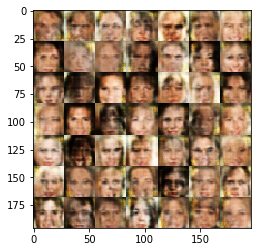

Epoch 1/1... Discriminator Loss: -89.3631... Generator Loss: -101.7931
Epoch 1/1... Discriminator Loss: -176.0136... Generator Loss: 32.5415
Epoch 1/1... Discriminator Loss: -631.6359... Generator Loss: 329.3075
Epoch 1/1... Discriminator Loss: -298.7809... Generator Loss: -69.7138
Epoch 1/1... Discriminator Loss: -46.7052... Generator Loss: -223.5085
Epoch 1/1... Discriminator Loss: -140.9841... Generator Loss: -50.0427
Epoch 1/1... Discriminator Loss: -10.7544... Generator Loss: 425.6656
Epoch 1/1... Discriminator Loss: -48.5266... Generator Loss: 398.2528
Epoch 1/1... Discriminator Loss: -257.2188... Generator Loss: -11.6720
Epoch 1/1... Discriminator Loss: -348.3832... Generator Loss: 407.8007


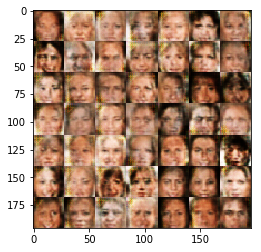

Epoch 1/1... Discriminator Loss: -12.9262... Generator Loss: 419.0208
Epoch 1/1... Discriminator Loss: 4.5575... Generator Loss: 380.6317
Epoch 1/1... Discriminator Loss: -33.5110... Generator Loss: 397.6543
Epoch 1/1... Discriminator Loss: -101.3506... Generator Loss: 258.7837
Epoch 1/1... Discriminator Loss: -429.6819... Generator Loss: 116.8245
Epoch 1/1... Discriminator Loss: -295.0789... Generator Loss: 183.3800
Epoch 1/1... Discriminator Loss: -196.3252... Generator Loss: 153.2899
Epoch 1/1... Discriminator Loss: -430.5746... Generator Loss: 330.6998
Epoch 1/1... Discriminator Loss: -377.2181... Generator Loss: 26.6777
Epoch 1/1... Discriminator Loss: -84.1782... Generator Loss: -251.5966


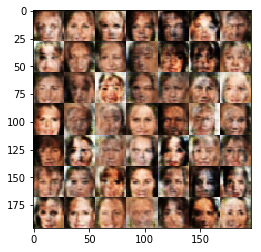

Epoch 1/1... Discriminator Loss: -307.3986... Generator Loss: 185.6543
Epoch 1/1... Discriminator Loss: -56.0593... Generator Loss: 432.0086
Epoch 1/1... Discriminator Loss: -152.5495... Generator Loss: 410.7635
Epoch 1/1... Discriminator Loss: -137.2903... Generator Loss: 418.0913
Epoch 1/1... Discriminator Loss: 154.7909... Generator Loss: -253.5337
Epoch 1/1... Discriminator Loss: -326.7058... Generator Loss: 34.0819
Epoch 1/1... Discriminator Loss: -179.7512... Generator Loss: 426.9096
Epoch 1/1... Discriminator Loss: -236.7325... Generator Loss: 175.2517
Epoch 1/1... Discriminator Loss: -231.2874... Generator Loss: 358.6038
Epoch 1/1... Discriminator Loss: -370.4438... Generator Loss: 297.9160


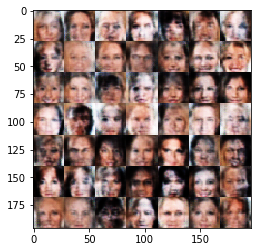

Epoch 1/1... Discriminator Loss: -205.9890... Generator Loss: 74.1274
Epoch 1/1... Discriminator Loss: -73.5036... Generator Loss: 135.4965
Epoch 1/1... Discriminator Loss: -27.1424... Generator Loss: -375.3098
Epoch 1/1... Discriminator Loss: -87.3057... Generator Loss: 126.1422
Epoch 1/1... Discriminator Loss: -116.6155... Generator Loss: -49.1899
Epoch 1/1... Discriminator Loss: -247.8309... Generator Loss: 397.0673
Epoch 1/1... Discriminator Loss: -369.5237... Generator Loss: 409.3571
Epoch 1/1... Discriminator Loss: 26.6263... Generator Loss: -265.3087
Epoch 1/1... Discriminator Loss: -154.2383... Generator Loss: 3.9129
Epoch 1/1... Discriminator Loss: -91.7477... Generator Loss: 259.5011


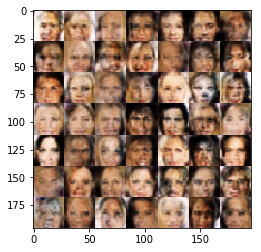

Epoch 1/1... Discriminator Loss: -250.9238... Generator Loss: 364.8782
Epoch 1/1... Discriminator Loss: -101.8193... Generator Loss: -282.1785
Epoch 1/1... Discriminator Loss: -64.8868... Generator Loss: 293.3674
Epoch 1/1... Discriminator Loss: -24.3289... Generator Loss: 465.8857
Epoch 1/1... Discriminator Loss: -776.6431... Generator Loss: 387.1054
Epoch 1/1... Discriminator Loss: -71.2036... Generator Loss: 58.3500
Epoch 1/1... Discriminator Loss: -239.5399... Generator Loss: -16.3618
Epoch 1/1... Discriminator Loss: -118.3061... Generator Loss: 222.0248
Epoch 1/1... Discriminator Loss: -199.5195... Generator Loss: 239.2577
Epoch 1/1... Discriminator Loss: -474.6219... Generator Loss: 254.6966


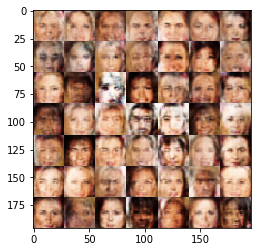

Epoch 1/1... Discriminator Loss: -177.2803... Generator Loss: 75.7157
Epoch 1/1... Discriminator Loss: -232.6899... Generator Loss: 421.8142
Epoch 1/1... Discriminator Loss: -300.8705... Generator Loss: 418.8707
Epoch 1/1... Discriminator Loss: -46.0871... Generator Loss: -5.7208
Epoch 1/1... Discriminator Loss: -66.7611... Generator Loss: 459.0400
Epoch 1/1... Discriminator Loss: -259.5307... Generator Loss: -69.7008
Epoch 1/1... Discriminator Loss: 65.0407... Generator Loss: -311.8990
Epoch 1/1... Discriminator Loss: 18.3950... Generator Loss: 448.6480
Epoch 1/1... Discriminator Loss: 35.1071... Generator Loss: 436.2953
Epoch 1/1... Discriminator Loss: 48.4368... Generator Loss: 426.1517


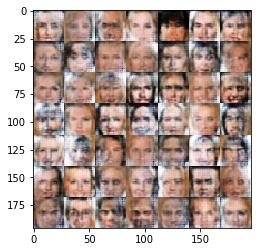

Epoch 1/1... Discriminator Loss: 29.0705... Generator Loss: 448.9320
Epoch 1/1... Discriminator Loss: -0.3977... Generator Loss: 472.8287
Epoch 1/1... Discriminator Loss: 2.2315... Generator Loss: 458.9545
Epoch 1/1... Discriminator Loss: -8.4550... Generator Loss: 454.9841
Epoch 1/1... Discriminator Loss: -3.5285... Generator Loss: 444.4795
Epoch 1/1... Discriminator Loss: -0.2169... Generator Loss: 433.7872
Epoch 1/1... Discriminator Loss: 16.9393... Generator Loss: 430.4751
Epoch 1/1... Discriminator Loss: 11.2648... Generator Loss: 437.0398
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 435.5781
Epoch 1/1... Discriminator Loss: -11.1450... Generator Loss: 431.7780


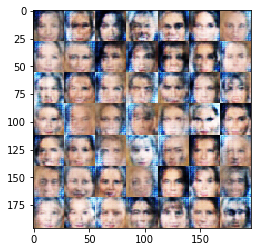

Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 429.3121
Epoch 1/1... Discriminator Loss: 33.5589... Generator Loss: 378.4692
Epoch 1/1... Discriminator Loss: 6.3544... Generator Loss: 441.2212
Epoch 1/1... Discriminator Loss: -7.0082... Generator Loss: 424.9144
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 415.8169
Epoch 1/1... Discriminator Loss: -6.3827... Generator Loss: 391.6404
Epoch 1/1... Discriminator Loss: 15.3316... Generator Loss: 422.5120
Epoch 1/1... Discriminator Loss: -2.1523... Generator Loss: 428.6253
Epoch 1/1... Discriminator Loss: 11.0805... Generator Loss: 405.2156
Epoch 1/1... Discriminator Loss: 7.5415... Generator Loss: 439.3406


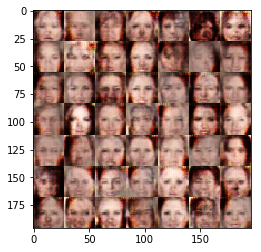

Epoch 1/1... Discriminator Loss: -6.0975... Generator Loss: 428.1337
Epoch 1/1... Discriminator Loss: -2.2969... Generator Loss: 416.5382
Epoch 1/1... Discriminator Loss: -0.6104... Generator Loss: 373.8773
Epoch 1/1... Discriminator Loss: -14.9771... Generator Loss: 394.0113
Epoch 1/1... Discriminator Loss: 3.7028... Generator Loss: 419.6398
Epoch 1/1... Discriminator Loss: 9.5716... Generator Loss: 425.2347
Epoch 1/1... Discriminator Loss: -1.2234... Generator Loss: 422.3181
Epoch 1/1... Discriminator Loss: 21.5286... Generator Loss: 334.4856
Epoch 1/1... Discriminator Loss: -6.3718... Generator Loss: 434.0616
Epoch 1/1... Discriminator Loss: 8.0145... Generator Loss: 419.0410


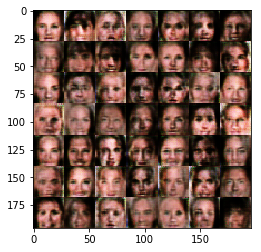

Epoch 1/1... Discriminator Loss: -7.6149... Generator Loss: 414.8332
Epoch 1/1... Discriminator Loss: 47.2549... Generator Loss: 331.6409
Epoch 1/1... Discriminator Loss: 10.3169... Generator Loss: 423.6817
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 402.2356
Epoch 1/1... Discriminator Loss: 2.3083... Generator Loss: 415.6789
Epoch 1/1... Discriminator Loss: 2.8750... Generator Loss: 425.5482


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.